<a href="https://colab.research.google.com/github/Earth15145/bsc_dpdm24/blob/main/final_competition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.0 MB/s eta 0:00:00


Data overview:
  id number    Xn  Hb(Gm%)  Hct(%)  MCV(fl)  A2 (2-3%)  HbF (2%)  \
0    67d169  25.0     11.1    34.0     78.0        3.2       0.0   
1    67l168  32.0     13.9    42.0     86.0        3.7       0.3   
2    67i267  43.0     10.1    31.0     78.0        2.6       0.3   
3    67e248  33.0     12.9    38.0     76.0        3.0       0.2   
4    67h277  23.0     12.9    40.0     78.0        3.1       0.0   

   HbA (95-97%)       RBC        MCH       MCHC  MCV-RBC-3*HGB  MCV-RBC-5*HGB  \
0          55.9  4.358974  25.464706  32.647059      40.341026      18.141026   
1          54.8  5.197674  28.859060  33.557047      35.802326       5.802326   
2          56.2  3.974359  25.412903  32.580645      43.725641      23.525641   
3          61.2  5.000000  25.800000  33.947368      32.300000       6.500000   
4          55.6  5.128205  25.155000  32.250000      34.171795       8.371795   

   |80-MCV|  |27-MCH|  |80-MCV|*|27-MCH|         Thal_Group  
0       2.0  1.535294      

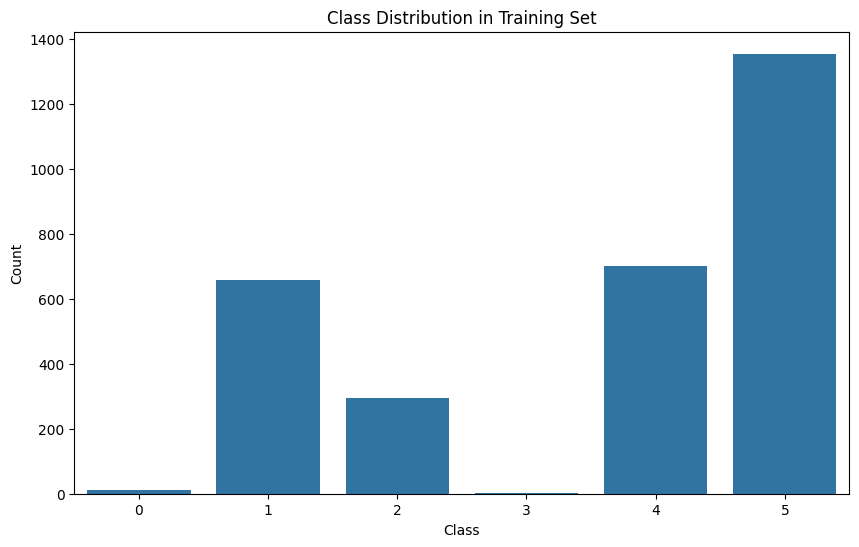


Applying SMOTE to handle class imbalance...
Shape after SMOTE: (8130, 3040)

Class distribution after SMOTE:
1    0.166667
5    0.166667
4    0.166667
2    0.166667
0    0.166667
3    0.166667
Name: proportion, dtype: float64

Training base models...
Training Logistic Regression...
Logistic Regression - Accuracy: 0.8441, F1: 0.8442
Training Decision Tree...
Decision Tree - Accuracy: 0.9259, F1: 0.9241
Training Random Forest...
Random Forest - Accuracy: 0.9367, F1: 0.9355
Training Gradient Boosting...
Gradient Boosting - Accuracy: 0.9306, F1: 0.9306
Training KNN...
KNN - Accuracy: 0.8827, F1: 0.8877
Training SVM...
SVM - Accuracy: 0.9136, F1: 0.9135
Training Naive Bayes...
Naive Bayes - Accuracy: 0.0448, F1: 0.0479
Training XGBoost...
XGBoost - Accuracy: 0.9429, F1: 0.9421
Training LightGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001839 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you 

In [ ]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as sp
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import warnings
from imblearn.over_sampling import SMOTE
import joblib
warnings.filterwarnings('ignore')

# อ่านข้อมูล
try:
    df = pd.read_csv('/content/drive/MyDrive/BSC DPDM 24 Machine Learning Competition 653020219-0 Aranchai/train_set.csv')
except FileNotFoundError as e:
    print("File not found. Please ensure the file path is correct.")
    raise e

# แสดงข้อมูลเบื้องต้น
print("Data overview:")
print(df.head())
print("\nData shape:", df.shape)
print("\nData info:")
print(df.info())
print("\nMissing values:")
print(df.isnull().sum())
print("\nData statistics:")
print(df.describe())

# การจัดการกับค่า missing values
print("\nHandling missing values...")
numeric_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = df.select_dtypes(include=['object']).columns.tolist()

# กำหนดคอลัมน์ target
target_column = 'Thal_Group'  # เปลี่ยนจาก 'target' เป็นชื่อคอลัมน์ที่ถูกต้อง
if target_column in numeric_features:
    numeric_features.remove(target_column)
if target_column in categorical_features:
    categorical_features.remove(target_column)

# Feature Engineering และ Preprocessing
print("\nPerforming feature engineering and preprocessing...")

# แยกข้อมูล features และ target
X = df.drop(columns=[target_column])
y = df[target_column]

# ถ้า target ไม่ได้เป็นตัวเลข ให้แปลงเป็นตัวเลข
if y.dtype == 'object':
    le = LabelEncoder()
    y = le.fit_transform(y)
    print(f"Encoded target classes: {le.classes_}")

# สร้าง preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numeric_features),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ]), categorical_features)
    ])

# แบ่งข้อมูลเป็น train, validation, test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training set: {X_train.shape}, Validation set: {X_val.shape}, Test set: {X_test.shape}")

# ตรวจสอบความไม่สมดุลของข้อมูล
if len(np.unique(y_train)) <= 10:
    print("\nClass distribution in training set:")
    train_class_counts = pd.Series(y_train).value_counts(normalize=True)
    print(train_class_counts)

    plt.figure(figsize=(10, 6))
    sns.countplot(x=pd.Series(y_train))
    plt.title('Class Distribution in Training Set')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.show()

# ใช้ SMOTE เพื่อจัดการข้อมูลไม่สมดุล
if len(np.unique(y_train)) <= 10:  # Only apply for classification with not too many classes
    print("\nApplying SMOTE to handle class imbalance...")
    smote = SMOTE(random_state=42, k_neighbors=2)

    # ทำ preprocessing ก่อน SMOTE
    X_train_preprocessed = preprocessor.fit_transform(X_train)
    X_val_preprocessed = preprocessor.transform(X_val)
    X_test_preprocessed = preprocessor.transform(X_test)

    X_train_smote, y_train_smote = smote.fit_resample(X_train_preprocessed, y_train)

    print(f"Shape after SMOTE: {X_train_smote.shape}")
    print("\nClass distribution after SMOTE:")
    print(pd.Series(y_train_smote).value_counts(normalize=True))
else:
    X_train_smote = preprocessor.fit_transform(X_train)
    y_train_smote = y_train
    X_val_preprocessed = preprocessor.transform(X_val)
    X_test_preprocessed = preprocessor.transform(X_test)

# สร้างฟังก์ชันสำหรับการประเมินประสิทธิภาพของโมเดล
def evaluate_model(model, X_train, y_train, X_val, y_val, model_name):
    # Convert X_val to a dense numpy array if it's sparse and the model is Naive Bayes
    if model_name == 'Naive Bayes' and sp.issparse(X_val):
        X_val = X_val.toarray()

    y_pred = model.predict(X_val)

    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_val, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_val, y_pred, average='weighted', zero_division=0)
    cm = confusion_matrix(y_val, y_pred)

    roc_auc = None
    if len(np.unique(y_val)) == 2:
        if hasattr(model, "predict_proba"):
            y_prob = model.predict_proba(X_val)[:, 1]
            fpr, tpr, _ = roc_curve(y_val, y_prob)
            roc_auc = auc(fpr, tpr)

    return {
        'Model': model_name,
        'Model Object': model,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'Confusion Matrix': cm,
        'ROC AUC': roc_auc
    }

# สร้างโมเดลพื้นฐาน
print("\nTraining base models...")
base_models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'KNN': KNeighborsClassifier(),
    'SVM': SVC(probability=True, random_state=42),
    'Naive Bayes': GaussianNB(),
    'XGBoost': XGBClassifier(random_state=42),
    'LightGBM': LGBMClassifier(random_state=42),
    'CatBoost': CatBoostClassifier(random_state=42, verbose=0)
}

# เก็บผลลัพธ์ของโมเดลพื้นฐาน
base_results = []

for name, model in base_models.items():
    print(f"Training {name}...")
    if name == 'Naive Bayes' and sp.issparse(X_train_smote):
        model.fit(X_train_smote.toarray(), y_train_smote)
    else:
        model.fit(X_train_smote, y_train_smote)

    result = evaluate_model(model, X_train_smote, y_train_smote, X_val_preprocessed, y_val, name)
    base_results.append(result)
    print(f"{name} - Accuracy: {result['Accuracy']:.4f}, F1: {result['F1 Score']:.4f}")

# สร้าง DataFrame เพื่อเปรียบเทียบผลลัพธ์ของโมเดลพื้นฐาน
base_comparison = pd.DataFrame([
    {
        'Model': r['Model'],
        'Accuracy': r['Accuracy'],
        'Precision': r['Precision'],
        'Recall': r['Recall'],
        'F1 Score': r['F1 Score'],
        'ROC AUC': r['ROC AUC'] if r['ROC AUC'] is not None else np.nan
    }
    for r in base_results
])

print("\nBase Models Comparison:")
print(base_comparison.sort_values('F1 Score', ascending=False))

# เลือกและปรับแต่งโมเดลที่ดีที่สุด 3 อันดับแรก
top_models = base_comparison.sort_values('F1 Score', ascending=False).head(3)['Model'].values
print(f"\nTop 3 models for hyperparameter tuning: {top_models}")

# สร้างโมเดลและ parameter grid สำหรับปรับแต่ง
tuning_params = {}
tuned_models = {}

# ตัวอย่างการกำหนด parameter grid สำหรับแต่ละโมเดล
if 'Logistic Regression' in top_models:
    tuning_params['Logistic Regression'] = {
        'C': [0.01, 0.1, 1, 10, 100],
        'solver': ['newton-cg', 'lbfgs', 'liblinear'],
        'penalty': ['l2']
    }

if 'Decision Tree' in top_models:
    tuning_params['Decision Tree'] = {
        'max_depth': [None, 5, 10, 15, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }

if 'Random Forest' in top_models:
    tuning_params['Random Forest'] = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    }

if 'Gradient Boosting' in top_models:
    tuning_params['Gradient Boosting'] = {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7]
    }

if 'KNN' in top_models:
    tuning_params['KNN'] = {
        'n_neighbors': [3, 5, 7, 9],
        'weights': ['uniform', 'distance'],
        'algorithm': ['auto', 'ball_tree', 'kd_tree']
    }

if 'SVM' in top_models:
    tuning_params['SVM'] = {
        'C': [0.1, 1, 10],
        'gamma': ['scale', 'auto', 0.1, 1],
        'kernel': ['rbf', 'linear']
    }

if 'XGBoost' in top_models:
    tuning_params['XGBoost'] = {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5, 7],
        'colsample_bytree': [0.7, 0.9]
    }

if 'LightGBM' in top_models:
    tuning_params['LightGBM'] = {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1],
        'max_depth': [-1, 5, 10],
        'num_leaves': [31, 63, 127]
    }

if 'CatBoost' in top_models:
    tuning_params['CatBoost'] = {
        'iterations': [100, 200],
        'learning_rate': [0.01, 0.1],
        'depth': [4, 6, 8]
    }

# ปรับจูน hyperparameters สำหรับโมเดลที่ดีที่สุด
print("\nPerforming hyperparameter tuning for top models...")

for name in top_models:
    if name in tuning_params:
        print(f"Tuning {name}...")

        model = base_models[name]

        grid_search = GridSearchCV(
            estimator=model,
            param_grid=tuning_params[name],
            cv=3,
            scoring='f1_weighted',
            n_jobs=-1,
            verbose=1
        )

        grid_search.fit(X_train_smote, y_train_smote)

        print(f"Best parameters for {name}: {grid_search.best_params_}")
        print(f"Best score: {grid_search.best_score_:.4f}")

        tuned_models[f"Tuned {name}"] = grid_search.best_estimator_

# บันทึกโมเดลที่ดีที่สุด
for name, model in tuned_models.items():
    filename = f"{name.replace(' ', '_')}.pkl"
    joblib.dump(model, filename)
    print(f"Saved {name} as {filename}")